In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy as sc
import pandas as pd

from scipy.optimize import curve_fit # For fitting redshift distribution
from scipy.optimize import brentq
import scipy.integrate as integrate  # For integration
from PIL import Image

In [2]:
# Defining constants
c = 3e+8             # speed of light in m/s
AU = 1.5e+11       # astronomical unit = 149.6 million km
G = 6.67e-11      # Gravitational constant in Nm^2 kg^-2 == m^3 kg^-1 s^-2
pc = 3e+16       # parsec = 3.26 light years = 206,000 AU = 30.9 trillion km
Gpc = 1e9*pc
H_0 = 70e3           # Cosmological constant in m/(s Mpc)

# Defining radius and mass parameters of the system
M_sun = 2e+30    # in kg
M_earth = 6e+24 / M_sun # in solar masses
r_sun = 7e+8    # 696,340 km
r_earth = 6.4e+6    # 6371 km

# Function to calculate location of L2, under reduced mass constraint
# R = distance between two masses M1, M2
# M1 = Mass of the larger object
# M2 = Mass of the smaller object
# https://en.wikipedia.org/wiki/Lagrange_point#L2
# Output: Langrange point distance in AU
def L2_point(R, M1, M2):
    return (R*(M2/(3*M1))**(1/3)) / AU

In [3]:
redshift = np.genfromtxt('redshift.csv',delimiter=',')

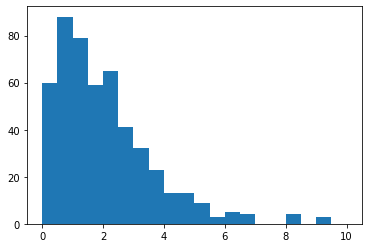

In [4]:
fig,ax = plt.subplots(1,1)
bins = np.linspace(0, 10, 21)
data_entries, bins = np.histogram(redshift, bins=bins)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
ax.hist(redshift, bins = bins)
plt.show()

In [5]:
def fit_function(x, A, alpha):
    return (A * x * np.exp(-x*alpha))

In [6]:
popt, pcov = curve_fit(fit_function, xdata=binscenters, ydata=data_entries, p0=[240,1.3])
print(popt)

[247.52234509   1.02585546]


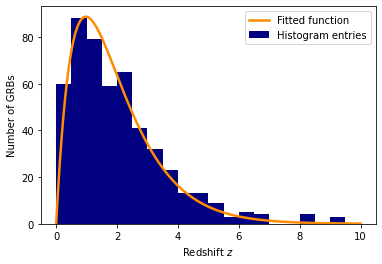

In [7]:
xspace = np.linspace(0, 10, 100000)
plt.bar(binscenters, data_entries, width=bins[1] - bins[0], color='navy', label=r'Histogram entries')
plt.plot(xspace, fit_function(xspace, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')
plt.xlabel(r'Redshift $z$')
plt.ylabel(r'Number of GRBs')
#plt.title(r'Exponential decay with gaussian peak')
plt.legend(loc='best')
#plt.savefig('fitted_distribution.png')
plt.show()

Refer [scipy tutorial](https://riptutorial.com/scipy/example/31081/fitting-a-function-to-data-from-a-histogram) for further information

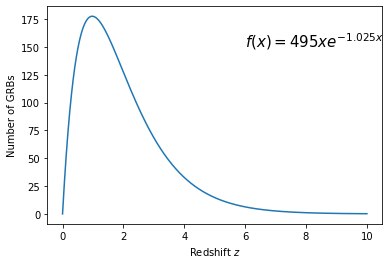

In [8]:
popt2 = np.array([247.52234509, 1.02585546])
popt2[0] /= 0.5
fig = plt.figure()
ax = fig.add_subplot()
plt.xlabel(r'Redshift $z$')
plt.ylabel(r'Number of GRBs')
plt.plot(xspace, fit_function(xspace,*popt2))
ax.text(6, 150, r'$f(x)=495x e^{-1.025x}$', fontsize=15)
#plt.savefig('distribution accounting for bin size.png')
plt.show()

In [9]:
Num_GRBs = lambda z_S: popt2[0] * z_S * np.exp(-popt2[1] * z_S) # Number of GRBs in +/- 0.05 for a given redshift
GRB_distribution = lambda z_S: popt2[0] * z_S * np.exp(-popt2[1] * z_S) / integrate.quad(Num_GRBs, 0, 10)[0] # GRB progenitor distribution as a function of redshift
Pr_GRB_zS = lambda z_S: integrate.quad(GRB_distribution, z_S - 0.25, z_S + 0.25) # Probability of selected GRB having z_S +/- 0.25 redshift

In [10]:
GRB_dbt_bin_size = 20
Pr_GRB_zS_numeric = np.zeros(GRB_dbt_bin_size)
for i in range(GRB_dbt_bin_size):
    Pr_GRB_zS_numeric[i] = Pr_GRB_zS(10/GRB_dbt_bin_size*i + 10/GRB_dbt_bin_size/2)[0]

In [11]:
Pr_GRB_zS_numeric

array([0.09418673, 0.17967312, 0.18139002, 0.15279999, 0.1179485 ,
       0.08646377, 0.06125533, 0.04235567, 0.02876067, 0.01925626,
       0.01274859, 0.00836301, 0.0054443 , 0.00352139, 0.00226507,
       0.00144999, 0.00092433, 0.00058706, 0.00037163, 0.00023457])

In [12]:
# Block to randomly sample points from GRB progenitor distribution
num_GRB_samples = 1000
l = []
for i in range(GRB_dbt_bin_size):
    for j in range(int(Pr_GRB_zS_numeric[i]*10000)): # 10000 multiplier covers 99.88% of the population space, 1000 -> 99.0%, 100000 -> 99.99%
        l.append(np.random.rand()/2 + i*10/GRB_dbt_bin_size)

In [13]:
GRB_list = np.array(l)
np.random.shuffle(GRB_list)

In [14]:
np.size(GRB_list)

9988

In [15]:
sim_GRB_list = np.zeros(num_GRB_samples)
size_GRB_list = np.shape(GRB_list)[0]
for i in range(num_GRB_samples):
    sim_GRB_list[i] = GRB_list[np.random.randint(size_GRB_list)]

In [16]:
np.min(sim_GRB_list),np.max(sim_GRB_list)

(0.009035876696709022, 9.842177038875654)

$$D_S = \frac{z_sc}{H_0}$$
$$\theta_E = \sqrt{\frac{4GM}{c^2}\frac{1}{D}}$$
$$r_E = \theta_e D_L$$

In [17]:
c/(H_0*1e3)    # Above expression applicable for D_S ~ c/H_0

4.285714285714286

In [18]:
np.mean(sim_GRB_list*c/H_0*1e-3),np.max(sim_GRB_list*c/H_0*1e-3)

(8.42698773181896, 42.18075873803853)

In [19]:
# Function to calculate Einstein angle of a lensing system
# M = mass of the lens
# D = Effective lensing distance
# Output: Einstein angle in radians
def Einstein_angle(M, D):
    return np.sqrt((4*G*(M*M_sun))/(c**2 * (D*1e9*pc)))

num_samples = 1000

# Defining lensing system parameters (lengths)
DL = 1       # Distance between lens and observer in Gpc (simplifying assumption)
DS = sim_GRB_list*c/(H_0*1e3)# Distance between source and observer in Gpc
DLS = DS - DL    # Distance between lens and source in Gpc (assuming small deviation and flat universe)
D = DL*DS/DLS    # Effective lensing distance in Gpc
D = 1            # As given in the paper
print("D =",D)
x_lens = DL/DS   # Ratio of distance to lens to distance to source from observer (Range = [0,1])
#beta = np.linspace(-1e-28,1e-28,num_samples)    # Angular position of source in radians

# Defining lensing system parameters (times)
#t_var =          # Minimum variability time scale
#T_90 =           # Observed burst duration

# Defining lensing system parameters
#M = np.logspace(-16, -11, num_samples)    # Mass of lens in solar masses
M = 1e-13      # Mass of lens in solar masses (simplifying assumption)
z_L = 0          # Redshift of lens (simplifying approximation)

# Derived parameters
theta_E = Einstein_angle(M, D)    # def Einstein_angle(M, D)
print("$theta_E$ =",theta_E)
r_E = theta_E * DL                # Einstein radius in Gpc

D = 1
$theta_E$ = 4.445555416701378e-18


(array([261., 340., 188., 121.,  53.,  20.,  15.,   1.,   0.,   1.]),
 array([3.87251858e-02, 4.25292854e+00, 8.46713190e+00, 1.26813353e+01,
        1.68955386e+01, 2.11097420e+01, 2.53239453e+01, 2.95381487e+01,
        3.37523520e+01, 3.79665554e+01, 4.21807587e+01]),
 <BarContainer object of 10 artists>)

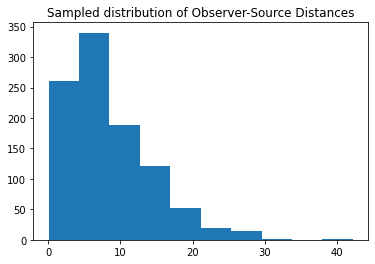

In [20]:
plt.title('Sampled distribution of Observer-Source Distances')
plt.hist(DS)

In [21]:
#Delta_t_d = 2 * 1e-5 * M    # time delay in seconds
r_Sch = 1e-5 * M * c         # Schwarzschild radius in metres
#u = 1e-28 / theta_E         # Position of the source

In [22]:
# Conservative
epsilon = 0.1
nu = 1.2e+20    # 0.5 MeV
NGRB = 10**3
# Delta_r = np.array(((2*r_earth) / AU, L2_point(R, M_sun, M_earth), 2))     # distances in AU
                                                                       # def L2_point(R, M1, M2)
                                                                       # Delta_r[0] = 2*r_earth, Delta_r[1] = L2_point, Delta_r[2] = 2*AU

In [ ]:
# Optimistic
epsilon = 0.01
nu = 1.2e+21    # 5 MeV
NGRB = 10**4
# Delta_r = np.array(((2*r_earth) / AU, L2_point(R, M_sun, M_earth), 2))    # distances in AU
                                                                       # def L2_point(R, M1, M2)
                                                                       # Delta_r[0] = 2*r_earth, Delta_r[1] = L2_point, Delta_r[2] = 2*AU

 - From 1. $$\Delta r \gtrsim r_E \Leftrightarrow M_{max} \lesssim \left(\frac{\Delta r}{AU}\right)^2 \left(\frac{Gpc}{D}\right)10^{-7}M_\odot$$
 - From 2. $$M_{min} \gtrsim \epsilon \left(\frac{r_S}{r_\odot}\right)^2 \left(\frac{Gpc}{D}\right) 10^{-12}M_\odot$$
 - From 3. for GRBs with $f = 10^{19} - 10^{21}$ and negligible $z_L$ $$M_{min} \gtrsim (10^{-15} - 10^{-17})M_\odot$$

In [23]:
'''
# Function to calculate the upper and lower bound for lens' mass in units of solar masses
def Lensing_parallax_conditions(Delta_r, M, r_E, D):
    prefactor_1 = (AU**2) / (M_sun * (1e9 * pc)) * ((c**2) / (4 * G))
    M_upper = prefactor_1 * (Delta_r)**2 * (1/D)
    # WARNING: NOT INCLUDED RADIOMETRIC RESOLUTION CONDITION
    prefactor_2 = (r_sun**2) / ((1e9 * pc) * M_sun) * ((c**2) / (4 * G))
    prefactor_3 = (0.1 * (c**3)) / (2 * G) * 1 / (nu * (1 + z_L)) * 1 / (M_sun)
    M_lower = np.max((prefactor_2 * epsilon * (1/D) * (r_S)**2), (prefactor_3))
    if ((M > M_lower) and (M < M_upper)):
        print(M," is in the given mass range", M_lower, " to ", M_upper)
    else:
        print(M," is not in the given mass range", M_lower, " to ", M_upper)
'''

'\n# Function to calculate the upper and lower bound for lens\' mass in units of solar masses\ndef Lensing_parallax_conditions(Delta_r, M, r_E, D):\n    prefactor_1 = (AU**2) / (M_sun * (1e9 * pc)) * ((c**2) / (4 * G))\n    M_upper = prefactor_1 * (Delta_r)**2 * (1/D)\n    # WARNING: NOT INCLUDED RADIOMETRIC RESOLUTION CONDITION\n    prefactor_2 = (r_sun**2) / ((1e9 * pc) * M_sun) * ((c**2) / (4 * G))\n    prefactor_3 = (0.1 * (c**3)) / (2 * G) * 1 / (nu * (1 + z_L)) * 1 / (M_sun)\n    M_lower = np.max((prefactor_2 * epsilon * (1/D) * (r_S)**2), (prefactor_3))\n    if ((M > M_lower) and (M < M_upper)):\n        print(M," is in the given mass range", M_lower, " to ", M_upper)\n    else:\n        print(M," is not in the given mass range", M_lower, " to ", M_upper)\n'

In [24]:
NGRB_small = 0.1 * NGRB    # "smallest GRBs with r_S < r_sun are the ones that allow to probe lightest unconstrained PBH mass range"
NGRB_tiny = 0.03 * NGRB    # r_S < 0.1 r_sun

In [25]:
#r_S = c * T_90        # Physical transverse emission size
#r_S = 0.1778 * r_sun   # in metres (simplifying assumption)
r_S = 0.1 * r_sun
#Gamma = c * T_90      # Lorentz boost

In [26]:
# Function to calculate magnification and brightness flux of each image
# u = beta/theta_E 
    # where beta is the angular position of the source
    # and theta_E is the Einstein angle of the given lensing system
# Output: individual magnifications of each image [mag_1, mag_2]
def image_magnification(u):
    mag_u = (u**2 + 2)/(2*u*np.sqrt(u**2 + 4))
    return np.abs(0.5 + mag_u), np.abs(0.5 - mag_u)

# Obtaining parameter values
# Output: total magnification. Calls image_magnification(u) as an intermediary
def total_magnification(u):
    [mu_plus,mu_minus] = image_magnification(u)
    A = mu_plus + mu_minus    # Observed magnification of unresolved images
    return A

In [27]:
# Function to calculate resolution of measured magnification
delta_A = lambda A1, A2: np.abs(A1 - A2) / ((A1 + A2)/2)

#A1 = total_magnification(u1)
#A2 = total_magnification(u2)
#delta_A(A1,A2)

### Appendix B: Finite source-size effect

In [28]:
# Function to calculate A_in
# Output: A_in
def A_in(u, delta):
    return (np.sqrt(1+ 4/(delta**2)) - 8 / (delta**3 * (delta**2 + 4)**1.5) * u**2/2 - 144 * (delta**4 + 2*delta**2 + 2) / (delta**5 * (delta**2 + 4)**3.5) * u**4/24)
    
# Function to calculate A_out
# Output: A_out
def A_out(u, delta):
    return ((2 + u**2) / (u*np.sqrt(u**2 + 4)) + (8*(u**2 + 1)) / (u**3 * (u**2 + 4)**2.5) * delta**2/2 + 48*(3*u**6 + 6*u**4 + 14*u**2 + 12) / (u**5 * (u**2 + 4)**4.5) * delta**4/24)

# Function to calculate the magnification of a finite sized circular source with constant surface brightness by a point-lens in the geometrical optics limit
# r_S = source size
# D = Effective lensing distance
# theta_E = Einstein angle
# u = Position of the source
# Output: Magnification
def finite_source_size_effect(r_S, D, theta_E, u):
    A = 0
    theta_S = r_S/(D * 1e9*pc)
    delta = theta_S/theta_E
    for i in range(1000):
        if np.abs(u)<=np.abs(0.9*delta):
            A = A_in(u,delta)
            #print(1)
        elif np.abs(u)>=np.abs(1.1*delta):
            A = A_out(u,delta)
            #print(2)
        else:
            A = (A_in(0.9*delta, delta)*(u - 0.9*delta)/0.2 + A_out(1.1*delta, delta)*(1.1*delta - u)/0.2)
            #print(3)
    return A

### Appendix C: Computing optical depth and constraints

In [29]:
D = 1#np.mean(DL*DS/DLS)
M = 1e-13
theta_E = Einstein_angle(M,D)
delta = (r_S/(D * 1e9*pc))/theta_E
print(D,delta)

1 0.5248687991982511


In [ ]:
calc_finite(np.arctan(AU/(1e9*pc*np.min(DS)) + np.tan(theta))/theta_E),calc_finite(np.arctan(AU/(1e9*pc*np.min(DS)) - np.tan(theta))/theta_E)

In [ ]:
theta = 3e-4
print(np.tan(theta))
(np.arctan(AU/(1e9*pc*DS[5]) + np.tan(theta))/theta_E)

In [ ]:
theta = 1e-15
calc_finite = lambda u: finite_source_size_effect(r_S, D, theta_E, u)
plt.title('Magnification vs DS')
xyz = np.zeros(num_samples)
for i in range(num_samples):
    xyz[i] = calc_finite(np.arctan(AU/(1e9*pc*DS[i]) + np.tan(theta))/theta_E)
plt.scatter(DS, xyz)
plt.show()
np.max(xyz)

In [30]:
# Simulation Framework for lens position under 2D planetary motion constraint
theta_tilt = 0    # Position of source wrt perp from planetary motion ellipse
beta1 = np.arctan(np.abs(np.cos(theta_tilt)*AU/(1e9*pc*DS) - np.tan(theta_tilt)))    # Angle with vertical at D1
beta2 = np.arctan(np.cos(theta_tilt)*AU/(1e9*pc*DS) + np.tan(theta_tilt))    # Angle with vertical at D2

u1 = beta1/theta_E
u2 = beta2/theta_E

x_plus = 1
x_minus = 1

np.min(u2 - delta), np.max(u2 - delta)

(26.1393944590763, 29043.07636744913)

In [31]:
finite_source_size_effect(r_S,D,theta_E,x_plus), finite_source_size_effect(r_S,D,theta_E,x_minus)

(1.3848666475179545, 1.3848666475179545)

In [ ]:
np.min(u1),np.max(u1)

In [ ]:
np.min(u2),np.max(u2)

In [ ]:
rho_crit_0 = (3 * ((H_0)**2)) / (8 * np.pi * G) * (pc*1e6) / M_sun # critical density in solar masses per Mpc^3
Omega_DM = 0.26
f = np.logspace(-4,0,num_samples)
n = lambda f: rho_crit_0 * Omega_DM * f / M 

# Dividing a region in the lens plans into 6400 rectangular sectors
num_sides = 10
arr_lens_plane_pos = np.zeros((num_sides,num_sides,num_samples))
'''
# Simulating magnification assuming A2 = 1 +/- 0.01
y1 = 0
A1 = 0
A2 = np.ones((1000))
# Loop to simulate magnification
while (1):
    y1 += 1
    print(y1)
    A1 = finite_source_size_effect(r_S, D, theta_E, y1)
    print(A1[500])
    A2 += 0.01
    if delta_A(A1[500],A2[500]) > (epsilon/2):
        break
'''
A1 = np.zeros(num_samples)
A2 = np.zeros(num_samples)
for i in range(num_samples):
    A1[i] = finite_source_size_effect(r_S, D, theta_E, u1[i])
    A2[i] = finite_source_size_effect(r_S, D, theta_E, u2[i])

print('Execution complete')

In [ ]:
np.min(A1), np.max(A1)

In [ ]:
np.min(A2), np.max(A2)

$$A_{1,2} > 1+\epsilon$$

In [32]:
# Calculate threshold u for particular value of r_S, D and theta_E
calc_finite = lambda u: finite_source_size_effect(r_S, D, theta_E, u)
u_T = brentq(calc_finite, -1, 1)
u_T

-0.47238191927781015

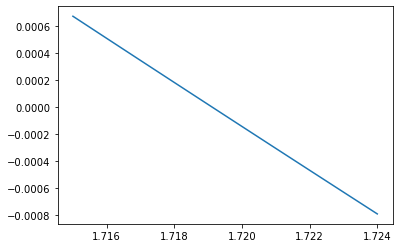

In [33]:
tmp_x = np.arange(1715,1725)/1000
tmp_y = np.zeros(10)
for i in range(10):
    tmp_y[i] = finite_source_size_effect(r_S, D, theta_E, tmp_x[i]) - 1.1
plt.plot(tmp_x, tmp_y)
plt.show()

In [34]:
np.min(tmp_y)

-0.0007911840793894953

In [35]:
finite_source_size_effect(r_S, D, theta_E, 1.719) -1.1

1.7981307610659414e-05

In [36]:
# FOR epsilon = 0.1, D = 1, M = 1e-13, u_T = 1.719
u_T = 1.719

In [37]:
finite_source_size_effect(r_S,D,theta_E,u_T)

1.1000179813076107

In [115]:
theta_E2 = Einstein_angle(M*1e10,D)
print(theta_E,theta_E2)

4.445555416701378e-18 4.445555416701378e-13


In [118]:
finite_source_size_effect(r_S,D,theta_E2,1.6)

1.1127380534571871

In [38]:
beta2 = np.arctan(AU/(1e9*pc*DS))
u2 = beta2/theta_E

In [39]:
calc_finite(u_T)

1.1000179813076107

In [40]:
tmp_x = np.linspace(0.01,0.99,99)
print(tmp_x)
tmp_DS = 2*c/(H_0*1e3)
print(tmp_DS)
tmp_D = tmp_DS*tmp_x/(1-tmp_x)
tmp_theta_E = np.zeros(99)
for i in range(99):
    tmp_theta_E[i] = Einstein_angle(M,tmp_D[i])
np.mean(tmp_theta_E),theta_E

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56
 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7
 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84
 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97 0.98
 0.99]
8.571428571428571


(2.1851159915114845e-18, 4.445555416701378e-18)

In [ ]:
num_masses = 51
M = np.logspace(-16,-11,num_masses)
D = 1
theta_E = np.zeros(num_masses)
Delta_r = AU

z_S = 2
DS = z_S*c/(H_0*1e3)

num_sides = 200
arr_lens_plane_pos = np.zeros((num_masses,num_sides,num_sides))

beta1 = 0
beta2 = 0
u1 = 0
u2 = 0

count = np.zeros(num_masses)
pixel_length_x = np.zeros(num_masses)
pixel_length_y = np.zeros(num_masses)

for k in range(num_masses):

    theta_E[k] = Einstein_angle(M[k],D)
    calc_finite = lambda u: finite_source_size_effect(r_S, D, theta_E[k], u)

    print('Iteration:',k)
    y = Gpc*DS*np.tan(u_T*theta_E[k])        # y in metres
    print('y =',y)
    Y = Delta_r + y                       # Y in metres
    print('Y =',Y)
    U_T = np.arctan(Y/(Gpc*DS))/theta_E[k]   # U_T is dimensionless
    print('U_T =',U_T)
    
    print(' ')

    pixel_length_x[k] = 2*Y / num_sides
    pixel_length_y[k] = 2*y / num_sides

    for j in range(num_sides):

        for i in range(int(num_sides/10)):
            tmp_x = ((i - num_sides/2) + 0.5)*pixel_length_x[k]
            tmp_y = ((j - num_sides/2) + 0.5)*pixel_length_y[k]

            beta2 = np.arctan(np.sqrt((tmp_x + Delta_r)**2 + tmp_y**2)/(Gpc*DS))
            beta1 = np.arctan(np.sqrt((tmp_x - Delta_r)**2 + tmp_y**2)/(Gpc*DS))

            u1 = beta1/theta_E[k]
            u2 = beta2/theta_E[k]

            A1 = calc_finite(u1)
            A2 = calc_finite(u2)

            if A1 > (1 + epsilon) or A2 > (1 + epsilon):
                if np.abs(A1 - A2)/(A1 + A2) > epsilon / 2:
                    count[k]+=1
                    arr_lens_plane_pos[k,i,j]=1

        for i in range(int(num_sides*9/10),num_sides):
            tmp_x = ((i - num_sides/2) + 0.5)*pixel_length_x[k]
            tmp_y = ((j - num_sides/2) + 0.5)*pixel_length_y[k]

            beta2 = np.arctan(np.sqrt((tmp_x + Delta_r)**2 + tmp_y**2)/(Gpc*DS))
            beta1 = np.arctan(np.sqrt((tmp_x - Delta_r)**2 + tmp_y**2)/(Gpc*DS))

            u1 = beta1/theta_E[k]
            u2 = beta2/theta_E[k]

            A1 = calc_finite(u1)
            A2 = calc_finite(u2)

            if A1 > (1 + epsilon) or A2 > (1 + epsilon):
                if np.abs(A1 - A2)/(A1 + A2) > epsilon / 2:
                    count[k]+=1
                    arr_lens_plane_pos[k,i,j]=1

Iteration: 0
y = 62140732.76368862
Y = 150062140732.7637
U_T = 4151.171195560081
 


In [316]:
# Creates PIL image
img = Image.fromarray(np.uint8(np.transpose(arr_lens_plane_pos[6]) * 255) , 'L')
#img.save('lens_distribution.png')
img.show()

In [317]:
count

array([  0., 140., 400., 400., 400., 400., 400.])

In [ ]:
i = 3
j = num_sides-4

tmp_x = ((i - num_sides/2) + 0.5)*pixel_length_x
tmp_y = ((j - num_sides/2) + 0.5)*pixel_length_y
print(tmp_x,tmp_y)
beta1 = np.arctan(np.sqrt((tmp_x - AU)**2 + tmp_y**2)/(Gpc*DS))
beta2 = np.arctan(np.sqrt((tmp_x + AU)**2 + tmp_y**2)/(Gpc*DS))
print(beta1,beta2)
u1 = beta1/theta_E[8]
u2 = beta2/theta_E[8]
print(u1,u2)
A1 = calc_finite(u1)
A2 = calc_finite(u2)

print(A1,A2)
print((np.abs(A1-A2))/((A1+A2)/2))

In [321]:
rho_crit_0 = (3 * ((H_0)**2)) / (8 * np.pi * G) * (pc*1e6) / M_sun * 1e9 # critical density in solar masses per Gpc^3
rho_crit_0 = 9.21e-27 / M_sun    # critical density in solar masses per m^3
Omega_DM = 0.26
f = np.logspace(-4,0,num_samples)
n = lambda f: rho_crit_0 * Omega_DM * f / M
print(n(1))

[1.19730000e-41 5.55737431e-42 2.57950465e-42 1.19730000e-42
 5.55737431e-43 2.57950465e-43 1.19730000e-43]


In [323]:
print(count[5]*pixel_length_x[5]*pixel_length_y[5])

2.547328647495396e+18


In [324]:
chi_S = DS*Gpc

V_L = np.zeros(num_masses)
for k in range(num_masses):
    sigma = lambda x_lens: (count[k]*pixel_length_x[k]*pixel_length_y[k]) * chi_S*x_lens**2
    V_L[k] = integrate.quad(sigma, 0, 1)[0]
print(V_L)

[0.00000000e+00 1.64278051e+43 6.89130717e+43 1.01192751e+44
 1.48621552e+44 2.18342455e+44 3.20904844e+44]


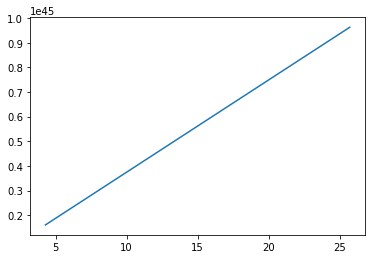

In [330]:
z_S2 = np.arange(1,7)
DS2 = z_S2*c/(H_0*1e3)
chi_S2 = DS2*Gpc
V_L2 = np.zeros(6)
for k in range(6):
    sigma = lambda x_lens: (count[6]*pixel_length_x[6]*pixel_length_y[6]) * chi_S2[k]*x_lens**2
    V_L2[k] = integrate.quad(sigma, 0, 1)[0]
plt.plot(DS2,V_L2)

# VARYING THRESHOLD u_T NOT TAKEN INTO ACCOUNT

In [325]:
f_final = np.zeros(num_masses)
for k in range(num_masses):
    tau = lambda f: n(f)[k] * V_L[k]
    print(tau(1e-1))
    
    P1 = lambda f: tau(f) * np.exp(-tau(f))
    P_null = lambda f: ((1 - P1(f))**(NGRB_tiny/1000))**1000
    
    num_f = 1000
    f = np.logspace(-4,0,num_f)
    #print(f)
    y_P = np.zeros(num_f)
    y_2 = np.ones(num_f)*0.05
    for i in range(num_f):
        y_P[i] = P_null(f[i])
    '''
    plt.title(M[k])
    plt.xlabel('f')
    plt.xscale('log')
    plt.yscale('log')
    plt.ylabel('P_null')
    plt.plot(f,y_2)
    plt.plot(f,y_P)
    plt.show()
    '''
    for l in range(num_f):
        if y_P[l] < 0.05:
            f_final[k] = f[l]
            break

print(f_final)

0.0
9.129546210064298
17.776158916338677
12.115808070025652
8.259455930347075
5.632153802089373
3.842193699088288
[0.         0.00116162 0.0005981  0.00087285 0.00128561 0.00187617
 0.00276339]


In [327]:
f_final2[0:4]=f_final[0:4]
M2[0:4]=M[0:4]

In [319]:
f_final2 = np.zeros(34)
f_final2[4:] = f_final
M2 = np.zeros(34)
M2[4:] = np.logspace(-15,-11,30)

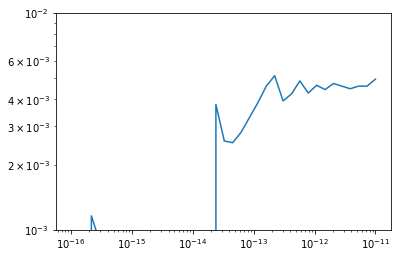

In [328]:
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-3,1e-2)
plt.plot(M2,f_final2)

In [278]:
f_final = np.zeros(num_masses)
for i in range(100):
    if y_P[i] < 0.05:
        f_final[k] = f[i]
        break
print(f_final)

0.0037649358067924714


In [204]:
# Calculating the bound for f
P_null = lambda f: ((1 - P1(f))**(NGRB_tiny/1000))**1000
print(P_null(10**(-1.5)))

0.00042231839278174385


In [205]:
print(tau(1e-1))

0.9853272982626475


In [206]:
f = 1
print(tau(f)*np.exp(-tau(f)))

0.0005180341971934305


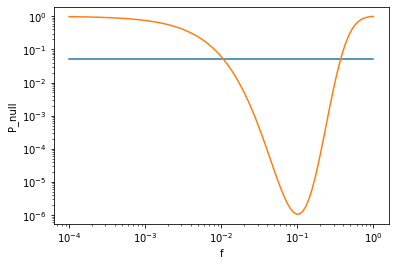

In [207]:
f = np.logspace(-4,0,100)
#print(f)
y_P = np.zeros(100)
y_2 = np.ones(100)*0.05
for i in range(100):
    y_P[i] = P_null(f[i])
plt.xlabel('f')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('P_null')
plt.plot(f,y_2)
plt.plot(f,y_P)

In [208]:
for i in range(100):
    if y_P[i] < 0.05:
        f_final[1] = f[i]
        break

In [209]:
f_final

array([0.        , 0.01149757, 0.00453488, 0.00284804, 0.        ,
       0.        , 0.        ])

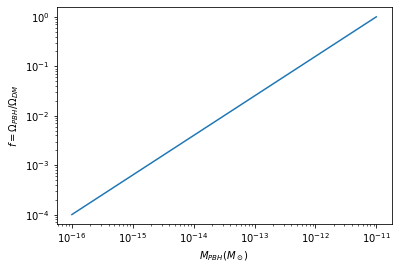

In [115]:
# Plot f vs Mass of lens
plt.plot(M, f)

plt.xlabel('$M_{PBH} (M_\odot)$')
plt.xscale('log')
#plt.xlim([1e-16,1e-11])
plt.ylabel('$f=\Omega_{PBH}/\Omega_{DM}$')
plt.yscale('log')
#plt.ylim([1e-4,1])

plt.show()

In [ ]:
# Plot Optical Depth vs Mass of lens
plt.plot(M, tau(f))

plt.xlabel('$M_{PBH} (M_\odot)$')
plt.xscale('log')
#plt.xlim([1e-16,1e-11])
plt.ylabel('Optical depth $\tau$')
plt.yscale('log')
#plt.ylim([1e-8,1e4])

plt.show()